# Data processing - Level 0

In [ ]:
from pathlib import Path

DATA_DIR = r"C:\Users\temel\Desktop\EERL\Campaigns\03_ORACLES\Neumayer_2024\Data"
DATA_DIRPATH = Path(DATA_DIR)
DATA_FLIGHT_DIRPATH = DATA_DIRPATH / "2024-2025_Sorted" / "2025-02-15_A"

If needed, reorder columns for FC.

In [ ]:
import pandas as pd

df1 = pd.read_csv(DATA_FLIGHT_DIRPATH / "HFC_250215_1.csv")  # replace with your actual filename

cols_to_move = [
    "MSsheath_rh", "MSsheath_temp", "MSpressure", "MSlfe_temp", "MSsheath_flow",
    "MSsheath_pwr", "MSimpct_prs", "MShv_volts", "MShv_dac", "MSsd_install",
    "MSext_volts", "MSmsems_errs", "MSmcpc_hrtb", "MSmcpc_smpf", "MSmcpc_satf",
    "MSmcpc_cndt", "MSmcpc_satt", "MSmcpc_sn", "MSmcpc_errs", "MSmcpcpwr",
    "MSmcpcpmp", "MSsd_save", "MSsave_flag"
]

cols_to_move = [col for col in cols_to_move if col in df1.columns]  # Ensure only existing columns are selected
first_col = ['Time'] if 'Time' in df1.columns else []  # Keep 'Time' at the start if present
other_cols = [col for col in df1.columns if col not in first_col + cols_to_move]  # Get all other columns not being moved
new_order = first_col + other_cols + cols_to_move  # Define the new column order
df2 = df1[new_order]  # Reorder the DataFrame

df2.to_csv(DATA_FLIGHT_DIRPATH / "HFC_250215_1_reordered.csv", index=False)
df2.head()

### Load flight data

In [ ]:
from helikite import Cleaner, instruments
import pandas as pd
import os
import datetime

cleaner = Cleaner(
    instruments=[
        instruments.flight_computer_v2,
        instruments.smart_tether,
        instruments.pops,
        instruments.msems_readings,
        instruments.msems_inverted,
        instruments.msems_scan,
        instruments.mcda,
        #instruments.tapir,
        #instruments.stap,
    ], 
    reference_instrument=instruments.flight_computer_v2,
    #reference_instrument=instruments.smart_tether,
    #reference_instrument=instruments.pops,
    input_folder=DATA_FLIGHT_DIRPATH,
    flight_date=datetime.date(2025,02,12),
    # time_takeoff=datetime.datetime(2024,4,2,10,0,35),
    # time_landing=datetime.datetime(2024,4,2,13,4,4),
    flight='59',
    time_offset=datetime.time(0),
)

cleaner.state()
#print(cleaner.flight_computer.df.head())

In [ ]:
cleaner.set_time_as_index()
cleaner.flight_computer.df = cleaner.fill_missing_timestamps(cleaner.flight_computer.df, freq="1s", fill_method="ffill")
#cleaner.pops.df = cleaner.fill_missing_timestamps(cleaner.pops.df, freq="1s", fill_method="ffill")
cleaner.msems_inverted.df['scan_direction'] = cleaner.msems_scan.df['scan_direction']  # To have 0 / 1 values when changing scans --> for removal of duplicates
cleaner.data_corrections()
cleaner.set_pressure_column()

**If needed, manually shift instrument by X seconds**

In [28]:
#cleaner.smart_tether.df = cleaner.smart_tether.df.shift(freq="-2s")       # ST
cleaner.pops.df = cleaner.pops.df.shift(freq="-50s")                       # POPS
#cleaner.msems_readings.df = cleaner.msems_readings.df.shift(freq="-7s")   # mSEMS readings
#cleaner.msems_inverted.df = cleaner.msems_inverted.df.shift(freq="-14s")  # mSEMS inverted
#cleaner.msems_scan.df = cleaner.msems_scan.df.shift(freq="-14s")          # mSEMS scan
#cleaner.mcda.df = cleaner.mcda.df.shift(freq="-1s")                       # mCDA

### Flight time definition
Chose start and end of the flight.  
2 cases for ORACLES :  
- Start and stop at sledge height
- Start and stop at balloon height (addition of 3.5 m later in the processing)

In [29]:
cleaner.define_flight_times()

    'data': [{'line': {'color': 'red', 'width': 2},
              'name': 'fligh…

In [20]:
print(cleaner.flight_computer.df.index.dtype)
#print(cleaner.smart_tether.df.index.dtype)
print(cleaner.pops.df.index.dtype)
print(cleaner.msems_readings.df.index.dtype)
print(cleaner.msems_inverted.df.index.dtype)
print(cleaner.msems_scan.df.index.dtype)
#print(cleaner.stap.df.index.dtype)
#print(cleaner.mcda.df.index.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### Cross correlation
Time synchronisation based on the pressure measured by the different instruments.

In [16]:
cleaner.correct_time_and_pressure(max_lag=180)

Cross correlation:
	Working on instrument: flight_computer
	Skipping reference instrument

	Working on instrument: pops
	Instrument: pops | Max val nan @ lag nans (≈ 0 rows)
	Shifting pops_ by 0 index

	Working on instrument: msems_readings
	Instrument: msems_readings | Max val nan @ lag nans (≈ 0 rows)
	Shifting msems_readings_ by 0 index

	Working on instrument: msems_inverted
	Instrument: msems_inverted | Max val nan @ lag nans (≈ 0 rows)
	Shifting msems_inverted_ by 0 index

	Working on instrument: msems_scan


C:\Users\temel\helikite-data-processing\Yolanda-helikite-data-processing\helikite\classes\cleaning.py:1092: FutureWarning:

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\temel\helikite-data-processing\Yolanda-helikite-data-processing\helikite\classes\cleaning.py:1092: FutureWarning:

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\temel\helikite-data-processing\Yolanda-helikite-data-processing\helikite\classes\cleaning.py:1092: FutureWarning:

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



	Instrument: msems_scan | Max val nan @ lag nans (≈ 0 rows)
	Shifting msems_scan_ by 0 index

Time and pressure corrections applied.
Note: Cross correlation df available at Cleaner.df_corr
Note: Pressure data available at Cleaner.df_pressure


C:\Users\temel\helikite-data-processing\Yolanda-helikite-data-processing\helikite\classes\cleaning.py:1092: FutureWarning:

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



In [5]:
# MANUAL TIME CORRECTION

cleaner.flight_computer.df = cleaner.flight_computer.df.shift(freq="2s")  # FC
cleaner.smart_tether.df = cleaner.smart_tether.df.shift(freq="-6s")       # ST
#cleaner.pops.df = cleaner.pops.df.shift(freq="64s")                       # POPS
#cleaner.msems_readings.df = cleaner.msems_readings.df.shift(freq="-7s")   # mSEMS readings
#cleaner.msems_inverted.df = cleaner.msems_inverted.df.shift(freq="-14s")  # mSEMS inverted
#cleaner.msems_scan.df = cleaner.msems_scan.df.shift(freq="-14s")          # mSEMS scan
#cleaner.mcda.df = cleaner.mcda.df.shift(freq="-1s")                       # mCDA

In [6]:
print(cleaner.df_corr.head())

                    pops  smart_tether  msems_readings  msems_inverted  \
pops            1.000000      0.999930        0.999297        0.997281   
smart_tether    0.999930      1.000000        0.998881        0.996903   
msems_readings  0.999297      0.998881        1.000000        0.997790   
msems_inverted  0.997281      0.996903        0.997790        1.000000   
msems_scan      0.997281      0.996903        0.997790        1.000000   

                msems_scan      mcda  smart_tether_1  smart_tether_2  \
pops              0.997281  0.999873        0.980033        0.980226   
smart_tether      0.996903  0.999971        0.978201        0.978401   
msems_readings    0.997790  0.998720        0.985178        0.985350   
msems_inverted    1.000000  0.996767        0.984120        0.984284   
msems_scan        1.000000  0.996767        0.984120        0.984284   

                smart_tether_3  smart_tether_4  ...  mcda_351  mcda_352  \
pops                  0.980420        0.980612 

### Dataframe creation
Removal of duplicates and merging instruments into one dataframe.

In [30]:
cleaner.remove_duplicates()
cleaner.merge_instruments()
# cleaner.export_data()

Set duplicate removal for (0/5): 
Errors (5/5):
Error (cleaner): 'Cleaner' object has no attribute 'mcda'
Error (cleaner): 'Cleaner' object has no attribute 'mcda'
Error (cleaner): 'Cleaner' object has no attribute 'mcda'
Error (cleaner): 'Cleaner' object has no attribute 'mcda'
Error (cleaner): 'Cleaner' object has no attribute 'mcda'
Using merge_asof to align and merge instrument dataframes.
Master dataframe created using merge_asof. Available at Cleaner.master_df.


### Overview plot of time synchronisation

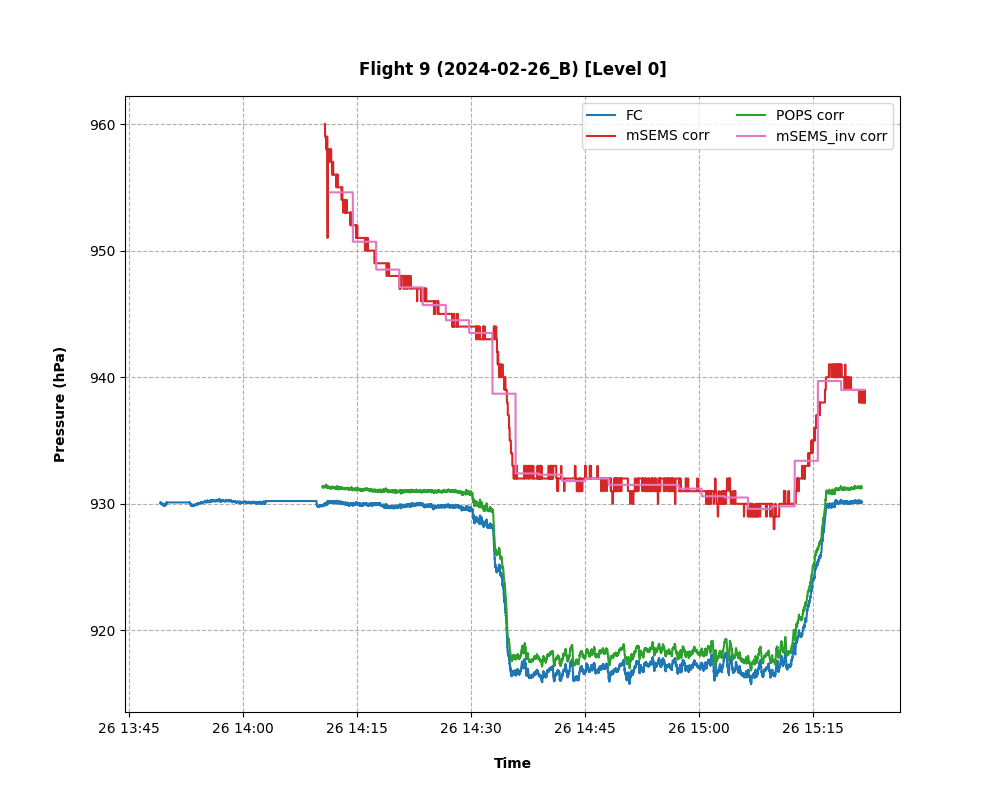

Saving figure to: C:\Users\temel\Desktop\EERL\Campaigns\01_Turtmann\data\Helikite\Processing\Level0\Level0_2024-02-26_B_Flight_9_TimeSync.png


In [31]:
import matplotlib
import numpy as np
import matplotlib.colors as mcols
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

%matplotlib ipympl
plt.close('all')
fig, (ax) = plt.subplots(1, 1, figsize=(10, 8))

# Flight Computer (FC) pressure data
ax.plot(cleaner.flight_computer.df_before_timeshift.index, cleaner.flight_computer.df_before_timeshift['pressure'], linestyle='dashed', color='C0', label='FC init')
ax.plot(cleaner.flight_computer.df.index, cleaner.flight_computer.df['pressure'], label='FC', color='C0')

# mSEMS Readings pressure data (before and after correction)
ax.plot(cleaner.msems_readings.df_before_timeshift.index, cleaner.msems_readings.df_before_timeshift['pressure'], linestyle='dashed', color='C3', label='mSEMS init')
ax.plot(cleaner.msems_readings.df.index, cleaner.msems_readings.df['pressure'], color='C3', label='mSEMS corr')

# Smart Tether pressure data (before and after correction)
ax.plot(cleaner.smart_tether.df_before_timeshift.index, cleaner.smart_tether.df_before_timeshift['pressure'], linestyle='dashed', color='C1', label='ST init')
#ax.plot(cleaner.smart_tether.df.index, cleaner.smart_tether.df['pressure'], label='ST corr', color='C1')

# POPS pressure data (before and after correction)
ax.plot(cleaner.pops.df_before_timeshift.index, cleaner.pops.df_before_timeshift['pressure'], linestyle='dashed', color='C2', label='POPS init')
ax.plot(cleaner.pops.df.index, cleaner.pops.df['pressure'], color='C2', label='POPS corr')

# mSEMS Inverted pressure data (before and after correction)
ax.plot(cleaner.msems_inverted.df_before_timeshift.index, cleaner.msems_inverted.df_before_timeshift['pressure'], linestyle='dashed', color='C6', label='mSEMS_inv init')
pressure_filled = cleaner.msems_inverted.df['pressure'].ffill()
ax.plot(cleaner.msems_inverted.df.index, pressure_filled, color='C6', label='mSEMS_inv corr')

# MCDA pressure data (before and after correction)
ax.plot(cleaner.mcda.df_before_timeshift.index, cleaner.mcda.df_before_timeshift['pressure'], linestyle='dashed', color='C4', label='mCDA init')
pressure_filled_mcda = cleaner.mcda.df['pressure'].ffill()
ax.plot(cleaner.mcda.df.index, pressure_filled_mcda, color='C4', label='mCDA corr')

ax.set_xlabel("Time", fontsize=10, labelpad=15, fontweight='bold')
ax.set_ylabel("Pressure (hPa)", fontsize=10, labelpad=15, fontweight='bold')
ax.set_title(f'Flight {cleaner.flight} ({cleaner.flight_date}_B) [Level 0]', fontsize=12, fontweight='bold', pad=15)
ax.grid(ls='--')
ax.legend(ncols=2)

# Show the plot
plt.show()

""" SAVE PLOT """
folder_path = r"C:\Users\temel\Desktop\EERL\Campaigns\01_Turtmann\data\Helikite\Processing\Level0"
filename = f'Level0_{cleaner.flight_date}_B_Flight_{cleaner.flight}_TimeSync.png'
save_path = f'{folder_path}\\{filename}'
print("Saving figure to:", save_path)
fig.savefig(save_path, dpi=300, bbox_inches='tight')

## Additional instruments

### CPC data

Addition of CPC3007 data into the dataframe

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# Step 1: Prepare master DataFrame
master_df = cleaner.master_df.copy()

# Step 2: Load and preprocess cpc data
file_path = DATA_FLIGHT_DIRPATH / "CPC_20250215_A.csv"
cpc_df = pd.read_csv(file_path, sep=",", engine='python', skiprows=17, skipfooter=1, header=0)
cpc_df = cpc_df.loc[:, ~cpc_df.columns.str.contains('^Unnamed')]
cpc_df = cpc_df.add_prefix("cpc_")

date = pd.to_datetime("2025-02-15")
cpc_df['cpc_DateTime'] = cpc_df['cpc_Time'].apply(lambda t: pd.to_datetime(f"{date.date()} {t}"))
cpc_df = cpc_df.set_index('cpc_DateTime', drop=False)
cpc_df.index.name = 'DateTime'

# Step 3: Resample to 1-second frequency and ffill
cpc_df_resampled = cpc_df.resample('1s').asfreq()
cpc_df_resampled.ffill(inplace=True)
cpc_df_resampled = cpc_df_resampled.rename(columns={'cpc_Concentration (#/cm3)': 'cpc_totalconc_raw'})

# Step 4: Join with master_df
master_df_joined = master_df.join(cpc_df_resampled, how="left")

display(cpc_df)
display(cpc_df_resampled)
display(master_df_joined)

## Level 0

In [32]:
cleaner.master_df = cleaner.shift_msems_columns_by_90s(cleaner.master_df)
#master_df_joined = cleaner.shift_msems_columns_by_90s(master_df_joined)
#cleaner.master_df = master_df_joined
cleaner.export_data()

Shifted msems_inverted and msems_scan columns by 90 seconds.

Done. The file 'level0_2024-02-26T13-49'.{csv|parquet} contains all instrument data. The metadata is stored in the Parquet file.
